In [11]:
import sys

import data_analysis_utils
import numpy as np
from pspy import pspy_utils, so_cov, so_dict, so_map, so_mcm, so_mpi, so_spectra

d = so_dict.so_dict()
# d.read_from_file(sys.argv[1])
%cd /global/cscratch1/sd/xzackli/PSpipe/project/data_analysis
d.read_from_file("paramfiles/global_dr6_v3_4pass_pa6_gaussian.dict")

/global/cscratch1/sd/xzackli/PSpipe/project/data_analysis


In [2]:
windows_dir = "windows"
mcms_dir = "mcms"
spectra_dir = "spectra"
ps_model_dir = "noise_model"
cov_dir = "covariances"
bestfit_dir = "best_fits"
sq_win_alms_dir = "sq_win_alms"

pspy_utils.create_directory(cov_dir)
surveys = d["surveys"]
binning_file = d["binning_file"]
lmax = d["lmax"]
niter = d["niter"]

fast_coupling = True
if fast_coupling:
    # This option is designed to be fast but is not for general usage
    # In particular we assume that the same window function is used in T and Pol
    # This loop check that this is what was specified in the dictfile
    for sv in surveys:
        arrays = d["arrays_%s" % sv]
        for ar in arrays:
            assert d["window_T_%s_%s" % (sv, ar)] == d["window_pol_%s_%s" % (sv, ar)], "T and pol windows have to be the same"


In [3]:

# spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]
spectra = ["TT", "TE", "ET",  "EE", "BE"]
spin_pairs = ["spin0xspin0", "spin0xspin2", "spin2xspin0", "spin2xspin2"]


In [4]:

ps_all = {}
nl_all = {}
spec_name = []
ns = {}

_, _, lb, _ = pspy_utils.read_binning_file(binning_file, lmax)

In [5]:

for id_sv1, sv1 in enumerate(surveys):
    arrays_1 = d["arrays_%s" % sv1]

    for id_ar1, ar1 in enumerate(arrays_1):
        _, bl1 = pspy_utils.read_beam_file(d["beam_%s_%s" % (sv1, ar1)])
        bl1 = bl1[2:lmax + 2]
        freq1 = d["nu_eff_%s_%s" % (sv1, ar1)]

        for id_sv2, sv2 in enumerate(surveys):
            arrays_2 = d["arrays_%s" % sv2]

            for id_ar2, ar2 in enumerate(arrays_2):
                _, bl2 = pspy_utils.read_beam_file(d["beam_%s_%s" % (sv2, ar2)])
                bl2 = bl2[2:lmax + 2]
                freq2 = d["nu_eff_%s_%s" % (sv2, ar2)]


                if  (id_sv1 == id_sv2) & (id_ar1 > id_ar2) : continue
                if  (id_sv1 > id_sv2) : continue

                if (sv1 == sv2) & (ar1 == ar2):
                    spec_name_noise = "mean_%sx%s_%s_noise" % (ar1, ar2, sv1)
                    _, Nl = so_spectra.read_ps(ps_model_dir + "/%s.dat" % spec_name_noise, spectra=spectra)

                for spec in ["TT", "TE", "ET", "EE"]:
                        
                    name = "%sx%s_%s" % (freq1, freq2, spec)
                    _, ps_th = np.loadtxt("%s/best_fit_%s.dat"%(bestfit_dir, name), unpack=True)


                    ps_all["%s&%s" % (sv1, ar1), "%s&%s" % (sv2, ar2), spec] = bl1 * bl2 * ps_th[:lmax]

                    if (sv1 == sv2) & (ar1 == ar2):
                        ns[sv1] = len(d["maps_%s_%s" % (sv1, ar1)])

                        nl_all["%s&%s" % (sv1, ar1), "%s&%s" % (sv2, ar2), spec] = Nl[spec][:lmax] * ns[sv1]
                    else:
                        nl_all["%s&%s" % (sv1, ar1), "%s&%s" % (sv2, ar2), spec] = np.zeros(lmax)

                    ps_all["%s&%s" % (sv2, ar2), "%s&%s"%(sv1, ar1), spec] = ps_all["%s&%s"%(sv1, ar1), "%s&%s"%(sv2, ar2), spec]
                    nl_all["%s&%s" % (sv2, ar2), "%s&%s"%(sv1, ar1), spec] = nl_all["%s&%s"%(sv1, ar1), "%s&%s"%(sv2, ar2), spec]

                spec_name += ["%s&%sx%s&%s" % (sv1, ar1, sv2, ar2)]


In [6]:

na_list, nb_list, nc_list, nd_list = [], [], [], []
ncovs = 0

for sid1, spec1 in enumerate(spec_name):
    for sid2, spec2 in enumerate(spec_name):
        if sid1 > sid2: continue
        na, nb = spec1.split("x")
        nc, nd = spec2.split("x")
        na_list += [na]
        nb_list += [nb]
        nc_list += [nc]
        nd_list += [nd]
        ncovs += 1

In [7]:

if d["use_toeplitz_cov"] == True:
    print("we will use the toeplitz approximation")
    l_exact, l_band, l_toep = 800, 2000, 2750
else:
    l_exact, l_band, l_toep = None, None, None

we will use the toeplitz approximation


In [8]:
print("number of covariance matrices to compute : %s" % ncovs)

number of covariance matrices to compute : 6


In [9]:
subtasks = so_mpi.taskrange(imin=0, imax=ncovs - 1)
print(subtasks)
for task in subtasks:
    task = int(task)
    na, nb, nc, nd = na_list[task], nb_list[task], nc_list[task], nd_list[task]
    na_r, nb_r, nc_r, nd_r = na.replace("&", "_"), nb.replace("&", "_"), nc.replace("&", "_"), nd.replace("&", "_")
    print("cov element (%s x %s, %s x %s)" % (na_r, nb_r, nc_r, nd_r))

MPI is not yet properly initialized. Are you sure this is what you want to do?
rank: 0 size: 1 ntask: 6 start: 0 end: 5
[0 1 2 3 4 5]
cov element (dr6_pa6_f090 x dr6_pa6_f090, dr6_pa6_f090 x dr6_pa6_f090)
cov element (dr6_pa6_f090 x dr6_pa6_f090, dr6_pa6_f090 x dr6_pa6_f150)
cov element (dr6_pa6_f090 x dr6_pa6_f090, dr6_pa6_f150 x dr6_pa6_f150)
cov element (dr6_pa6_f090 x dr6_pa6_f150, dr6_pa6_f090 x dr6_pa6_f150)
cov element (dr6_pa6_f090 x dr6_pa6_f150, dr6_pa6_f150 x dr6_pa6_f150)
cov element (dr6_pa6_f150 x dr6_pa6_f150, dr6_pa6_f150 x dr6_pa6_f150)


In [10]:
task = subtasks[1]

In [35]:
na, nb, nc, nd = na_list[task], nb_list[task], nc_list[task], nd_list[task]
na_r, nb_r, nc_r, nd_r = na.replace("&", "_"), nb.replace("&", "_"), nc.replace("&", "_"), nd.replace("&", "_")
print("cov element (%s x %s, %s x %s)" % (na_r, nb_r, nc_r, nd_r))

cov element (dr6_pa6_f090 x dr6_pa6_f090, dr6_pa6_f090 x dr6_pa6_f150)


In [36]:
spectra

['TT', 'TE', 'ET', 'EE', 'BE']

In [37]:
coupling = data_analysis_utils.fast_cov_coupling(sq_win_alms_dir,
                                                         na_r,
                                                         nb_r,
                                                         nc_r,
                                                         nd_r,
                                                         lmax,
                                                         l_exact=l_exact,
                                                         l_band=l_band,
                                                         l_toep=l_toep)

In [28]:
try:
    mbb_inv_ab, Bbl_ab = so_mcm.read_coupling(prefix="%s/%sx%s" % (mcms_dir, na_r, nb_r), spin_pairs=spin_pairs)
except:
    mbb_inv_ab, Bbl_ab = so_mcm.read_coupling(prefix="%s/%sx%s" % (mcms_dir, nb_r, na_r), spin_pairs=spin_pairs)

try:
    mbb_inv_cd, Bbl_cd = so_mcm.read_coupling(prefix="%s/%sx%s" % (mcms_dir, nc_r, nd_r), spin_pairs=spin_pairs)
except:
    mbb_inv_cd, Bbl_cd = so_mcm.read_coupling(prefix="%s/%sx%s" % (mcms_dir, nd_r, nc_r), spin_pairs=spin_pairs)

In [38]:
analytic_cov = data_analysis_utils.covariance_element(coupling,
                                                          [na, nb, nc, nd],
                                                          ns,
                                                          ps_all,
                                                          nl_all,
                                                          binning_file,
                                                          mbb_inv_ab,
                                                          mbb_inv_cd)

In [53]:
np.save("noise_Dl_dict_all_TEST.npy", nl_all)
np.save("signal_Dl_dict_all_TEST.npy", ps_all)

In [28]:
from pixell import enmap

In [29]:
enmap.read_map("/global/cfs/cdirs/sobs/sims/scan-s0002/v1/car/lat01_s25_large_tiles_fullfp_f150_1pass_2way_set01_div.fits")

ndmap([[9.48870716e+07 1.61103999e+08 1.11635226e+08 ... 1.08097528e+08
  7.24992437e+07 7.63123258e+07]
 [5.60837347e+07 9.17006703e+07 1.06649701e+08 ... 9.43122229e+07
  1.06825329e+08 8.03382437e+07]
 [2.04247744e+07 8.45915006e+07 8.80723671e+07 ... 5.63656328e+07
  8.74482801e+07 8.32417345e+07]
 ...
 [3.64131416e+07 3.29274553e+07 6.97661083e+07 ... 1.17373477e+08
  1.24554325e+08 9.88250715e+07]
 [8.05926674e+07 1.09793720e+08 9.13080606e+07 ... 1.28549367e+08
  1.09911671e+08 1.17146245e+08]
 [3.29313055e+07 1.02295361e+08 1.21033379e+08 ... 1.17289583e+08
  1.46844974e+08 1.58029134e+08]],car:{cdelt:[-0.008333,0.008333],crval:[180,0],crpix:[21601.00,7561.00]})

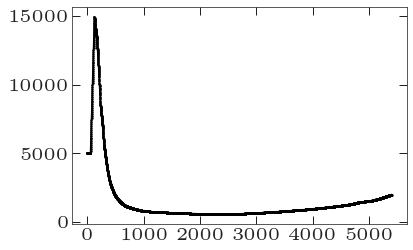

In [12]:
import matplotlib.pyplot as plt

plt.plot(nl_all[('dr6&pa6_f090',
  'dr6&pa6_f090',
  'TT')])

In [13]:
import matplotlib.pyplot as plt

In [14]:
from juliacall import Main as jl

[juliapkg] Locating Julia ^1.6
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] Using Julia 1.7.2 at /global/homes/x/xzackli/bin/julia-1.7.2/bin/julia
[juliapkg] Using Julia project at /global/homes/x/xzackli/.conda/envs/ps38/julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="PowerSpectra", uuid="87acb811-fa58-4e83-857d-605afdc1041b")])
           julia> Pkg.resolve()


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/global/u2/x/xzackli/.conda/envs/ps38/julia_env/Project.toml`
  No Changes to `/global/u2/x/xzackli/.conda/envs/ps38/julia_env/Manifest.toml`
  No Changes to `/global/u2/x/xzackli/.conda/envs/ps38/julia_env/Project.toml`
  No Changes to `/global/u2/x/xzackli/.conda/envs/ps38/julia_env/Manifest.toml`


In [15]:
jl.seval("using JLD2")

In [16]:
ps_all.keys()

dict_keys([('dr6&pa6_f090', 'dr6&pa6_f090', 'TT'), ('dr6&pa6_f090', 'dr6&pa6_f090', 'TE'), ('dr6&pa6_f090', 'dr6&pa6_f090', 'ET'), ('dr6&pa6_f090', 'dr6&pa6_f090', 'EE'), ('dr6&pa6_f090', 'dr6&pa6_f150', 'TT'), ('dr6&pa6_f150', 'dr6&pa6_f090', 'TT'), ('dr6&pa6_f090', 'dr6&pa6_f150', 'TE'), ('dr6&pa6_f150', 'dr6&pa6_f090', 'TE'), ('dr6&pa6_f090', 'dr6&pa6_f150', 'ET'), ('dr6&pa6_f150', 'dr6&pa6_f090', 'ET'), ('dr6&pa6_f090', 'dr6&pa6_f150', 'EE'), ('dr6&pa6_f150', 'dr6&pa6_f090', 'EE'), ('dr6&pa6_f150', 'dr6&pa6_f150', 'TT'), ('dr6&pa6_f150', 'dr6&pa6_f150', 'TE'), ('dr6&pa6_f150', 'dr6&pa6_f150', 'ET'), ('dr6&pa6_f150', 'dr6&pa6_f150', 'EE')])

In [23]:
D = jl.seval("""Dict{String, Vector{Float64}}()""")
for k in ps_all:
    jl.setindex_b(D, ps_all[k], "_".join(k))
jl.save("ps_all.jld2", D)

In [25]:
D = jl.seval("""Dict{String, Vector{Float64}}()""")
for k in nl_all:
    jl.setindex_b(D, nl_all[k], "_".join(k))
jl.save("nl_all.jld2", D)

In [6]:
import numpy as np

In [30]:
x = np.array([[1],[3],[2]])

In [36]:
import juliacall
juliacall.using(locals(), 'PowerSpectra', 'SpectralVector', rename=lambda x:'jl'+x.replace('!',''))

In [40]:
jlSpectralVector(np.array([1.0, 2.0, 3.0]))

3-element SpectralVector{Float64, PythonCall.PyArray{Float64, 1, true, true, Float64}} with indices 0:2:
 1.0
 2.0
 3.0

In [51]:
a = jl.seval("""Dict{Int, Float64}(1 => 1.0)""")

In [52]:
jl.print(a)

Dict(1 => 1.0)